# Endogenous model shifts

In [1]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
include("../julia/utils.jl");

## Fitting the Bayesian classifier

In [2]:
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

In [3]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [4]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [5]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);

In [6]:
model = bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁);
w = model.μ;

In [7]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [8]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

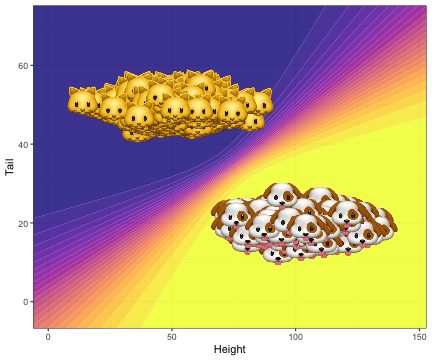

RObject{VecSxp}


In [9]:
ggplot() + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
  guides(fill="none") +
  scale_fill_viridis(option="C",discrete=true) +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  labs(x="Height", y="Tail") +
  theme_bw() # |>
  # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

## Generating recourse

In [10]:
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");

In [31]:
cats = df[(df.y.==0),:];
N_cats = size(cats,1);
N_unhappy_cats = round(0.1 * N_cats);
X_f = [rand(1:N_cats) for i in 1:N_unhappy_cats] |>
    indeces -> [[cats.x1[i], cats.x2[i]] for i in indeces];

37